# Estimate Diffusion Angle
---
This notebook estimates Noisy [1,2] parameters from Gaussian Random Fields movies. More specifically, the Adjoint method is used to estimate the opening angle of the diffusion tensor.

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [9]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy as sci
from ipywidgets import interact, fixed
import ipywidgets as widget
import pynoisy.eht_functions as ehtf
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.optimize import minimize

In [10]:
def compare_movie_frames(movie1, movie2):
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    plt.tight_layout()
    mean_images = [movie1.frames.mean(axis=0), 
                   movie2.frames.mean(axis=0), 
                   (np.abs(movie1.frames - movie2.frames)).mean(axis=0)]
    cbars = []
    for ax, image in zip(axes, mean_images):
        im = ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbars.append(fig.colorbar(im, cax=cax))
                     
    def imshow_frame(i, movie1, movie2, axes, cbars):
        image1 = movie1.frames[i]
        image2 = movie2.frames[i]
        image3 = np.abs(movie1.frames[i] - movie2.frames[i])
        
        for ax, img, title, cbar in zip(axes, [image1, image2, image3], 
                                        ['Movie1', 'Movie2', 'Absolute difference'], cbars):
            im = ax.imshow(img)
            ax.set_title(title)
            cbar.mappable.set_clim([img.min(), img.max()])
            
    interact(
        imshow_frame, i=(0, pynoisy.core.get_num_frames()-1), 
        movie1=fixed(movie1),movie2=fixed(movie2), axes=fixed(axes), cbars=fixed(cbars)
    );

class Optimizer(object):
    def __init__(self):
        self._nfeval = 0
        
    def objective_fun(self, x):
        diffusion = pynoisy.RingDiffusion(opening_angle=x)
        forward_solver = pynoisy.PDESolver(advection=advection_true, diffusion=diffusion)
        adjoint_solver = pynoisy.PDESolver(advection=-advection_true, diffusion=diffusion)
        random_field = forward_solver.run_adjoint(source=source, verbose=False)
        error = random_field.frames - random_field_true.frames
        loss = np.abs(error).mean()
        backprop = adjoint_solver.run_adjoint(source=pynoisy.Movie(error).reverse_time().frames, verbose=False)
        #backprop = forward_solver.run_adjoint(source=error, verbose=False)
    
        dx = 1e-2
        diffusion_f = pynoisy.RingDiffusion(opening_angle=x+dx)
        jac_source = (diffusion_f.get_laplacian(random_field.frames, advection_true.v) - 
                      diffusion.get_laplacian(random_field.frames, advection_true.v)) / dx
        gradient = np.mean(backprop.frames * np.flip(jac_source, axis=0))
        #gradient = np.mean(backprop.frames * jac_source)
        return np.array(loss), np.array(gradient)

    def callback_fun(self, x):
        print('{}    {}'.format(self._nfeval, x))
        self._nfeval += 1
        
    def minimize(self, x0):
        result = minimize(fun=self.objective_fun, x0=np.array(x0), method='L-BFGS-B', jac=True)
        return result

## Forward Model

### Generate synthetic measurements

In [ ]:
advection = pynoisy.DiskAdvection()
diffusion = pynoisy.RingDiffusion()
solver = pynoisy.PDESolver(advection, diffusion)
source = np.random.randn(solver.num_frames, *pynoisy.core.get_image_size()) * solver.forcing_strength
random_field = solver.run_adjoint(source=source, verbose=True)
random_field.save('./random_field_adjoint1')
np.save('./source_adjoint1', source)

Synthetic measurements


<IPython.core.display.Javascript object>


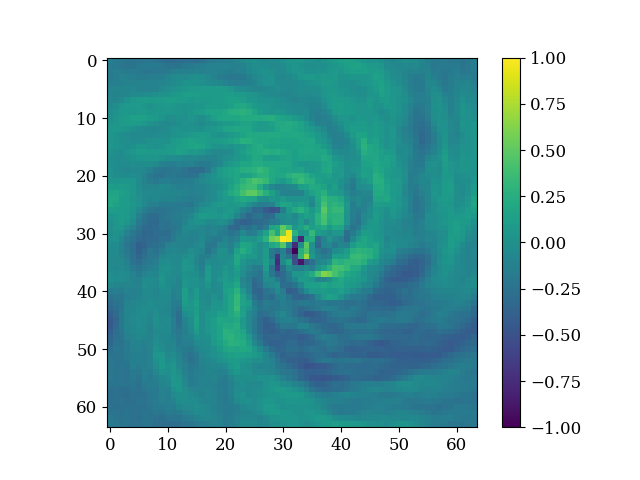

In [12]:
%matplotlib notebook
print('Synthetic measurements')
anim = random_field_true.get_animation(vmin=-1, vmax=1, output='true_angle.gif')

## Inverse Model

In [4]:
"""
Load true random field
"""
random_field_true = pynoisy.Movie()
random_field_true.load('./random_field_adjoint1')
source = np.load('./source_adjoint1.npy')

# True Advection / Diffusion
advection_true = pynoisy.DiskAdvection()
diffusion_true = pynoisy.RingDiffusion()

### Adjoint backpropogation

Initial guess


Traceback (most recent call last):
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


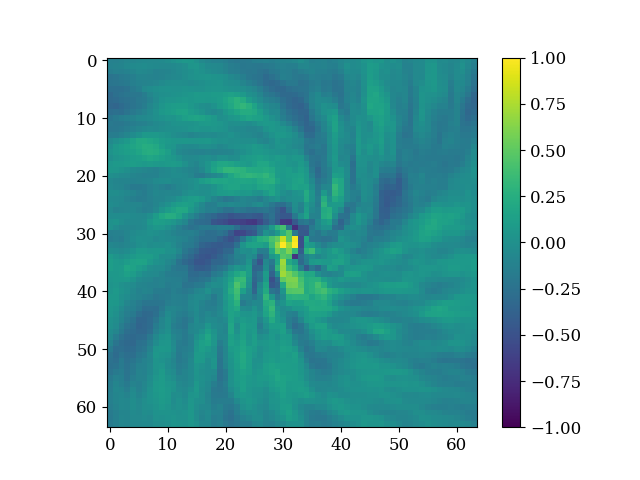

In [27]:
"""
Initilaize diffusion tensor angle with initial guess
"""
diffusion = pynoisy.RingDiffusion(opening_angle=0.6)
solver = pynoisy.PDESolver(advection_true, diffusion)
adjoint_solver = pynoisy.PDESolver(advection=-advection_true, diffusion=diffusion)
random_field = solver.run_adjoint(source=source)

print('Initial guess')
%matplotlib notebook
anim = random_field.get_animation(vmin=-1, vmax=1)

In [28]:
"""
Compute error and backpropogate (Adjoint) error through Noisy
"""
error = random_field_true.frames - random_field.frames
backprop = adjoint_solver.run_adjoint(source=error)

Error


<IPython.core.display.Javascript object>


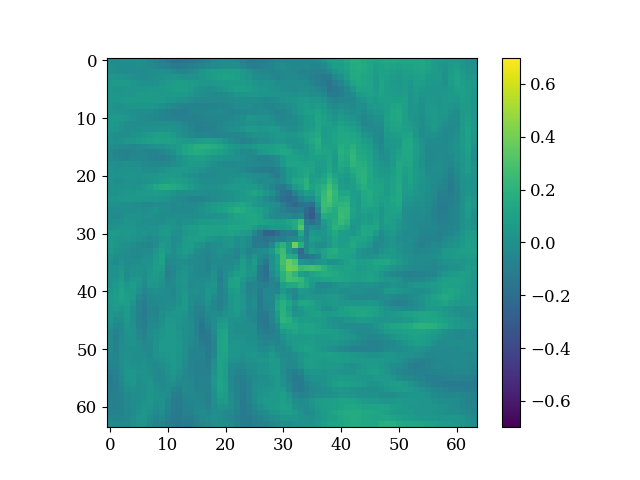

In [29]:
print('Error')
anim = pynoisy.Movie(error).get_animation(vmin=-0.7, vmax=0.7, output='error1.gif')

Adjoint (backpropogated) Error


<IPython.core.display.Javascript object>


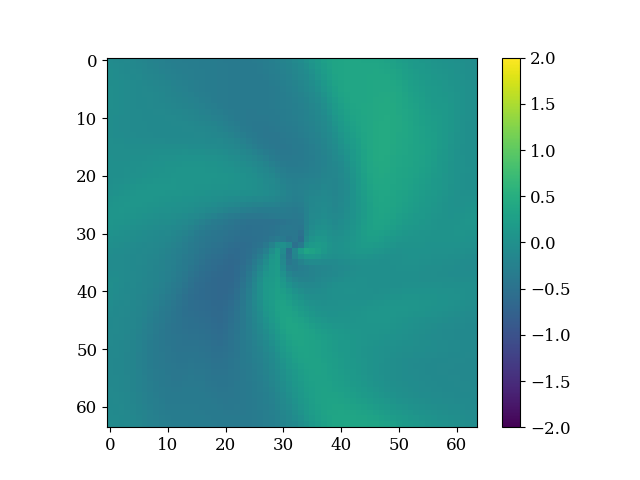

In [30]:
print('Adjoint (backpropogated) Error')
anim = backprop.get_animation(vmin=-2, vmax=2, output='adjoint2.gif')

### Loss / gradient analysis

In [ ]:
def objective_fun1(x):
    diffusion = pynoisy.RingDiffusion(opening_angle=x)
    forward_solver = pynoisy.PDESolver(advection=advection_true, diffusion=diffusion)
    random_field = forward_solver.run_adjoint(source=source, verbose=False)
    error = random_field.frames - random_field_true.frames
    loss = np.abs(error).mean()
    return loss

def objective_fun3(x):
    diffusion = pynoisy.RingDiffusion(opening_angle=x)
    forward_solver = pynoisy.PDESolver(advection=advection_true, diffusion=diffusion)
    random_field = forward_solver.run_adjoint(source=source, verbose=False)
    error = random_field.frames - random_field_true.frames
    loss = np.abs(error).mean()

    dx = 1e-2
    diffusion_f = pynoisy.RingDiffusion(opening_angle=x+dx)
    jac_source = (diffusion_f.get_laplacian(random_field.frames, advection_true.v) - 
                  diffusion.get_laplacian(random_field.frames, advection_true.v)) / dx
    jacobian = forward_solver.run_adjoint(source=jac_source, verbose=False)
    gradient = np.mean(error * jacobian.frames)
    return loss, gradient
    
def objective_fun2(x):
    diffusion = pynoisy.RingDiffusion(opening_angle=x)
    forward_solver = pynoisy.PDESolver(advection=advection_true, diffusion=diffusion)
    adjoint_solver = pynoisy.PDESolver(advection=-advection_true, diffusion=diffusion)
    random_field = forward_solver.run_adjoint(source=source, verbose=False)
    error = random_field.frames - random_field_true.frames
    loss = np.abs(error).mean()
    #backprop = adjoint_solver.run_adjoint(source=pynoisy.Movie(error).reverse_time().frames, verbose=False)
    backprop = forward_solver.run_adjoint(source=error, verbose=False)
    
    dx = 1e-2
    diffusion_f = pynoisy.RingDiffusion(opening_angle=x+dx)
    jac_source = (diffusion_f.get_laplacian(random_field.frames, advection_true.v) - 
                  diffusion.get_laplacian(random_field.frames, advection_true.v)) / dx
    
    #gradient = np.mean(backprop.frames * np.flip(jac_source, axis=0))
    gradient = np.mean(backprop.frames * jac_source)
    return loss, gradient

In [ ]:
cost1, cost2 = [], []
grad1, grad2 = [], []
theta_grid = np.linspace(0.0, 1.1 + np.pi, 40)
dx = 1e-3
for x in tqdm(theta_grid):
    c, g = objective_fun2(x)
    cost2.append(c)
    grad2.append(g)
    grad1.append((objective_fun1(x+dx) - c) / dx)

In [ ]:
%matplotlib notebook 

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].set_xlabel(r'$\theta$')
ax[0].set_ylabel(r'$F(\theta)$')
ax[0].set_title('Loss function')
ax[0].plot(theta_grid, cost2, label='Loss')
ax[0].axvline(x=diffusion_true.opening_angle, label='True angle', color='r', linestyle='--')
ax[1].axvline(x=diffusion_true.opening_angle, label='True angle', color='r', linestyle='--')
ax[1].plot(theta_grid, grad1, label='Numerical gradient')
ax[1].plot(theta_grid, grad2, label='Adjoint gradient')
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$\nabla F(\theta)$')
ax[1].set_title('Gradient comparison')

plt.legend()

In [ ]:
%matplotlib notebook 

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].set_xlabel(r'$\theta$')
ax[0].set_ylabel(r'$F(\theta)$')
ax[0].set_title('Loss function')
ax[0].plot(theta_grid, cost2, label='Loss')
ax[0].axvline(x=diffusion_true.opening_angle,  color='r', linestyle='--')
ax[1].axvline(x=diffusion_true.opening_angle, color='r', linestyle='--')
ax[1].axhline(y=0, label='True angle', color='r', linestyle='--')
ax[1].plot(theta_grid, grad1, label='Numerical gradient')
ax[1].plot(theta_grid, np.array(grad2)*0.05, label='Adjoint gradient')
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$\nabla F(\theta)$')
ax[1].set_title('Gradient comparison')

plt.legend()

### Full Optimization

In [5]:
"""
Optimization from many initial guesses. 
"""
optimizer = Optimizer()
x0_list = np.linspace(0.0, np.pi, 30)
results = []
for x0 in tqdm(x0_list):
    res = optimizer.minimize(x0)
    results.append(res.x)

<IPython.core.display.Javascript object>


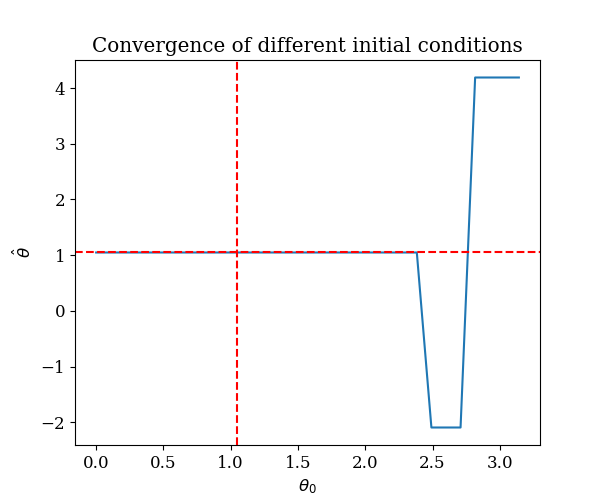

In [8]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\hat{\theta}$')
ax.set_title('Convergence of different initial conditions')
ax.plot(x0_list, np.array(results))
plt.axhline(y=diffusion_true.opening_angle, color='r', linestyle='--', label='True angle')
plt.axvline(x=diffusion_true.opening_angle, color='r', linestyle='--', label='True angle')